In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from sklearn.datasets import make_circles, make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from spectral_clustering import *
from stability_analysis import *
from parameter_fitting import *

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from pydiffmap import diffusion_map as dm
import pandas as pd
from sklearn.datasets import make_moons

# Shared color maps for presentation-friendly styling
PRESENTATION_CMAP = ListedColormap(PRESENTATION_COLORS)
TWO_CLUSTER_CMAP = ListedColormap(PRESENTATION_COLORS[:2])

In [3]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

In [4]:
X, y = make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=42)

In [5]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gmm = GaussianMixture(n_components=2, random_state=42)

y_kmeans = kmeans.fit_predict(X)
y_gmm = gmm.fit_predict(X)

In [6]:
distance_matrix = get_distance_matrix_from_data(X)
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn"
)

spectral_clustering = Spectral_Clustering(W=similarity_matrix, K=2)
y_spectral = spectral_clustering.labels

# Intro

Motivation and example when spectral clustering is better than GMM and K-Means

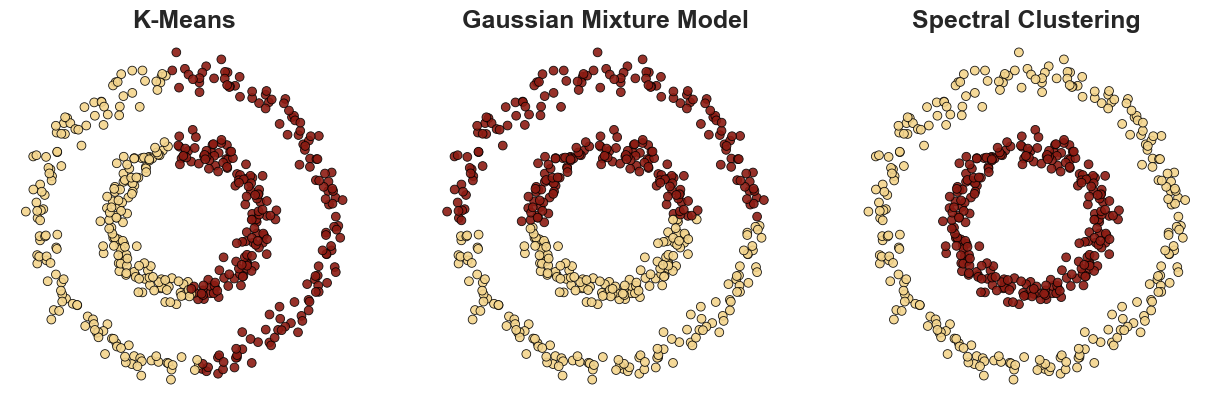

In [7]:
sns.set_theme(style="white", context="talk")
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5), sharex=True, sharey=True)
methods = [
    ("K-Means", y_kmeans),
    ("Gaussian Mixture Model", y_gmm),
    ("Spectral Clustering", y_spectral),
]
for ax, (title, labels) in zip(axes, methods):
    ax.scatter(
        X[:, 0],
        X[:, 1],
        c=labels,
        cmap=TWO_CLUSTER_CMAP,
        s=40,
        linewidths=0.6,
        edgecolor="black",
        alpha=0.9,
    )
    ax.set_title(title, fontweight="semibold")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

fig.subplots_adjust(wspace=0.06, top=0.85, bottom=0.05)
plt.show()

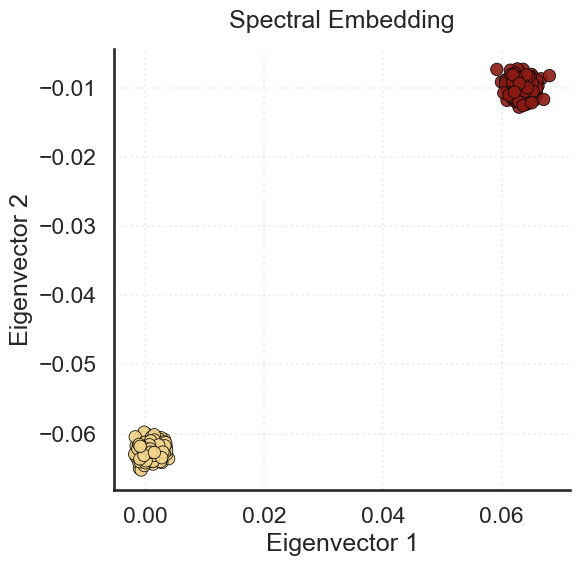

In [8]:
spectral_embedding = spectral_clustering.eigenvectors

plot_2d_spectral_embedding(spectral_embedding, cluster_labels=y_spectral)

# Moons

In [9]:
X, true_labels = make_moons(n_samples=250, noise=0.1, random_state=3)

In [10]:
distance_matrix = get_distance_matrix_from_data(X)

In [11]:
K = 2

parameter_grid_knn = {
    "sim_graph_type": ["knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [5, 8, 10, 15, 20, 30, 40],
    "mutual_knn": [0],
    "epsilon": [0],
}

In [12]:
best_params_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix, param_grid=parameter_grid_knn, random_state=1
)
print(best_params_knn)

{'K': 50, 'epsilon': 0, 'knn': 5, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0
Average eigenvalue:  -4.0557256046442237e-16
Estimated K:  2

{'K': 50, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 8, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 15, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 20, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 15, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.0

{'K': 50, 'epsilon': 0, 'knn': 20, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
Eigengap:  0.

In [13]:
best_params_knn

{'K': 2,
 'epsilon': 0,
 'knn': 5,
 'mutual_knn': 0,
 'sigma': 0,
 'sim_graph_type': 'knn'}

In [14]:
similarity_matrix = get_similarity_matrix_from_distance_matrix(
    distance_matrix, sim_graph_type="knn", knn=10
)

spectral_clustering = Spectral_Clustering(W=similarity_matrix, K=2, normalized=1)

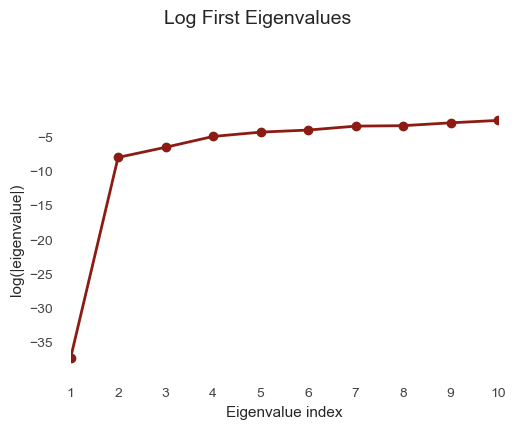

In [15]:
plot_eigenvalues([spectral_clustering.eigenvalues])

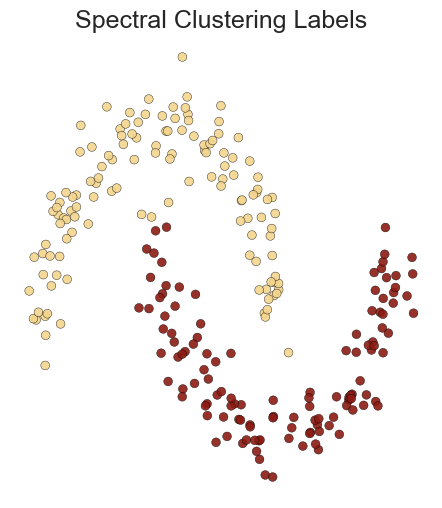

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

unique_labels = np.unique(spectral_clustering.labels)
cluster_cmap = ListedColormap(PRESENTATION_COLORS[: len(unique_labels)])

plt.scatter(
    X[:, 0],
    X[:, 1],
    c=spectral_clustering.labels,
    cmap=cluster_cmap,
    s=40,
    edgecolor="black",
    linewidths=0.3,
    alpha=0.9,
    vmin=unique_labels.min(),
    vmax=unique_labels.max(),
)
plt.title("Spectral Clustering Labels")
plt.xticks([])
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [17]:
row_norms = np.linalg.norm(spectral_clustering.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-12

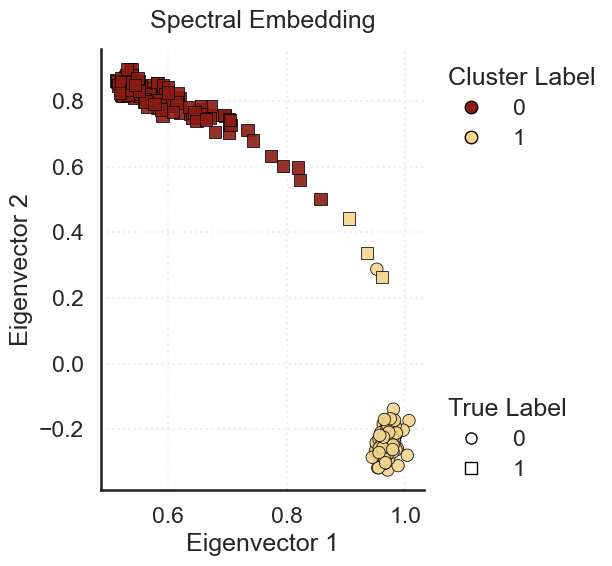

In [18]:
normalized_embedding = spectral_clustering.eigenvectors / row_norms
plot_2d_spectral_embedding(
    normalized_embedding,
    true_labels=true_labels,
    cluster_labels=spectral_clustering.labels,
)

In [19]:
stability_test_res_ami = cross_validation_stability_test(
    similarity_matrix,
    K_folds=20,
    K_clusters=K,
    info_score=adjusted_mutual_info_score,
    random_state=1,
)

stability_test_res_ars = cross_validation_stability_test(
    similarity_matrix,
    K_folds=20,
    K_clusters=K,
    info_score=adjusted_rand_score,
    random_state=1,
)

Fold 1: info_score(train vs full) = 0.9647
Fold 2: info_score(train vs full) = 1.0000
Fold 3: info_score(train vs full) = 0.9647
Fold 4: info_score(train vs full) = 0.9379
Fold 3: info_score(train vs full) = 0.9647
Fold 4: info_score(train vs full) = 0.9379
Fold 5: info_score(train vs full) = 1.0000
Fold 6: info_score(train vs full) = 0.9647
Fold 5: info_score(train vs full) = 1.0000
Fold 6: info_score(train vs full) = 0.9647
Fold 7: info_score(train vs full) = 0.9647
Fold 8: info_score(train vs full) = 0.9647
Fold 7: info_score(train vs full) = 0.9647
Fold 8: info_score(train vs full) = 0.9647
Fold 9: info_score(train vs full) = 0.9647
Fold 10: info_score(train vs full) = 0.9647
Fold 9: info_score(train vs full) = 0.9647
Fold 10: info_score(train vs full) = 0.9647
Fold 11: info_score(train vs full) = 0.9648
Fold 12: info_score(train vs full) = 0.9649
Fold 11: info_score(train vs full) = 0.9648
Fold 12: info_score(train vs full) = 0.9649
Fold 13: info_score(train vs full) = 0.9648
Fold

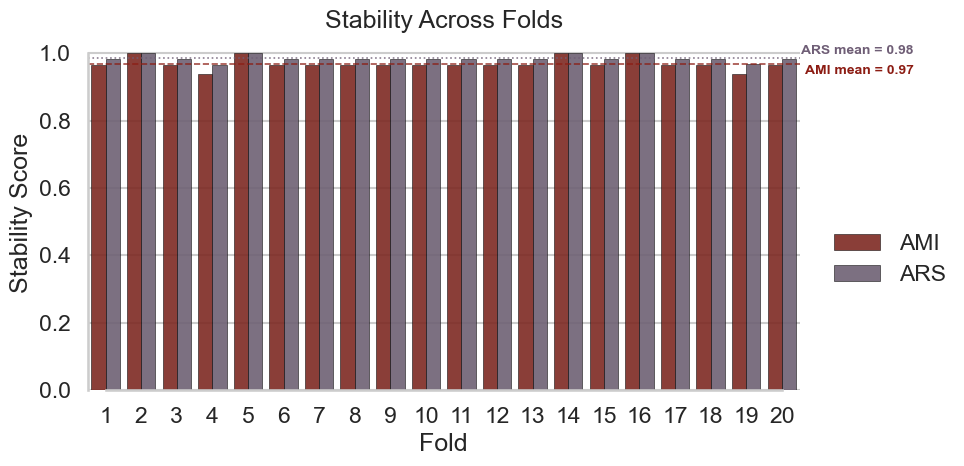

In [20]:
fold_scores_ami = np.asarray(stability_test_res_ami["fold_scores"], dtype=float)
fold_scores_ars = np.asarray(stability_test_res_ars["fold_scores"], dtype=float)

comparison_df = pd.DataFrame(
    {
        "Fold": np.tile(np.arange(1, fold_scores_ami.size + 1), 2),
        "Score": np.concatenate([fold_scores_ami, fold_scores_ars]),
        "Metric": ["AMI"] * fold_scores_ami.size + ["ARS"] * fold_scores_ars.size,
    }
)

metric_palette = {
    "AMI": PRESENTATION_COLORS[0],
    "ARS": PRESENTATION_COLORS[3],
}

sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=comparison_df,
    x="Fold",
    y="Score",
    hue="Metric",
    palette=metric_palette,
    edgecolor="black",
    linewidth=0.4,
    ax=ax,
    dodge=True,
    alpha=0.9,
)

ax.set_ylim(0.0, 1.05)
ax.set_ylabel("Stability Score")
ax.set_title("Stability Across Folds")
ax.legend(bbox_to_anchor=(1.02, 0.5), frameon=False)

ami_mean = fold_scores_ami.mean()
ars_mean = fold_scores_ars.mean()

ax.axhline(
    ami_mean, color=PRESENTATION_COLORS[0], linestyle="--", linewidth=1.2, alpha=0.8
)
ax.axhline(
    ars_mean, color=PRESENTATION_COLORS[3], linestyle=":", linewidth=1.2, alpha=0.8
)

ami_label_x = comparison_df["Fold"].max() + 2.7
ars_label_x = comparison_df["Fold"].max() + 2.7

ax.text(
    ami_label_x,
    ami_mean - 0.04,
    f"AMI mean = {ami_mean:.2f}",
    color=PRESENTATION_COLORS[0],
    va="bottom",
    ha="right",
    fontsize=10,
    fontweight="semibold",
)
ax.text(
    ars_label_x,
    ars_mean + 0.04,
    f"ARS mean = {ars_mean:.2f}",
    color=PRESENTATION_COLORS[3],
    va="top",
    ha="right",
    fontsize=10,
    fontweight="semibold",
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()